In [1]:
import os
import glob
import json
import torch
import pandas as pd

import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
NEURIPS_RCPARAMS = {
    "figure.autolayout": False,         # Makes sure nothing the feature is neat & tight.
    "figure.figsize": (2.65, 1.9),      # Text width: 5.5in (double figure minus spacing 0.2in).
    "figure.dpi": 150,                  # Displays figures nicely in notebooks.
    "axes.linewidth": 0.5,              # Matplotlib's current default is 0.8.
    "xtick.major.width": 0.5,
    "xtick.minor.width": 0.5,
    "ytick.major.width": 0.5,
    "ytick.minor.width": 0.5,
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",             # use serif rather than sans-serif
    "font.serif": "Times New Roman",    # use "Times New Roman" as the standard font
    "font.size": 7,
    "axes.titlesize": 7,                # LaTeX default is 10pt font.
    "axes.labelsize": 7,                # LaTeX default is 10pt font.
    "legend.fontsize": 7,               # Make the legend/label fonts a little smaller
    "legend.frameon": True,             # Remove the black frame around the legend
    "patch.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "lines.linewidth": 1.0,
    "lines.markersize": 4,
    "grid.linewidth": 0.3,
    "pgf.texsystem": "xelatex",         # use Xelatex which is TTF font aware
    "pgf.rcfonts": False,               # Use pgf.preamble, ignore standard Matplotlib RC
    "pgf.preamble": [
        r'\usepackage{fontspec}',
        r'\usepackage{unicode-math}',
        r'\setmainfont{Times New Roman}',
    ],
    'errorbar.capsize': 3.0,
}

matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
matplotlib.rcParams.update(NEURIPS_RCPARAMS)

In [3]:
EXP_DIR = "../output/dataRegimes-n10"

In [4]:
def extract_exp_name(output_fname):
    """Return the experiment name for an output filename"""
    return output_fname.split(os.path.sep)[-2]

In [5]:
def process_param_file(param_fname):
    """Process a parameter file"""
    with open(param_fname, 'r') as f:
        data = json.load(f)
    series = pd.concat((
        pd.Series(data['params']).apply(np.array), 
        pd.Series(data)
    ))
    del series['params']
    series['expId'] = os.path.split(param_fname)[0]
    return series


def extract_param_df(exp_dir):
    param_file_list = glob.glob(os.path.join(exp_dir, '*', 'params.json'))
    param_df = pd.DataFrame(list(map(process_param_file, param_file_list)))
    return param_df

In [6]:
import tsvar

def process_mle(data):
    """Process the output of a MLE run"""
    series = pd.Series(data['coeffs']).apply(np.array)
    series['conv'] = data['conv']
    series['history'] = data['history']
    # Add prefix
    series = series.rename({col:'mle_' + col for col in series.index})
    return series


def process_bbvi(data, dim=None):
    """Process the output of a BBVI run"""
    series = pd.Series()
    series['loc'] = np.array(data['coeffs']['loc'])
    series['log_scale'] = np.array(data['coeffs']['log-scale'])
    post = tsvar.posteriors.LogNormalPosterior()
    coeffs_mean = post.mean(torch.tensor(series['loc']), torch.tensor(series['log_scale'])).numpy()
    coeffs_mode = post.mode(torch.tensor(series['loc']), torch.tensor(series['log_scale'])).numpy()
    series['coeffs_mean'] = coeffs_mean
    series['coeffs_mode'] = coeffs_mode
    if dim:
        series['adj_mean'] = coeffs_mean[dim+dim**2:]
        series['adj_mode'] = coeffs_mean[dim+dim**2:]
    series['conv'] = data['conv']
    series['history'] = data['history']
    # Add prefix
    series = series.rename({col:'bbvi_' + col for col in series.index})
    return series


def process_vi(data):
    series = pd.Series(data['coeffs']).apply(np.array)
    series['conv'] = data['conv']
    series['history'] = data['history']
    # Extract mean/model posterior for coeffs
    model = tsvar.models.WoldModelVariational()
    series['adj_mode'] = model.alpha_posterior_mean(as_po=series['as_po'], ar_po=series['ar_po'])[1:,:]
    series['adj_mean'] = model.alpha_posterior_mode(as_po=series['as_po'], ar_po=series['ar_po'])[1:,:]
    # Add prefix
    series = series.rename({col:'vi_' + col for col in series.index})
    return series


def process_vi_fixed_beta(data):
    series = pd.Series(data['coeffs']).apply(np.array)
    series['conv'] = data['conv']
    series['history'] = data['history']
    # Extract mean/model posterior for coeffs
    model = tsvar.models.WoldModelVariationalFixedBeta()
    series['adj_mode'] = model.alpha_posterior_mean(as_po=series['as_po'], ar_po=series['ar_po'])[1:,:]
    series['adj_mean'] = model.alpha_posterior_mode(as_po=series['as_po'], ar_po=series['ar_po'])[1:,:]
    # Add prefix
    series = series.rename({col:'vi_fixed_beta_' + col for col in series.index})
    return series


def process_gb(data):
    series = pd.Series(data['coeffs']).apply(np.array)
    series['conv'] = data['conv']
    series['history'] = data['history']
    # Extract normalized adjacency
    series['adj_normed'] = series['adjacency'] / series['adjacency'].sum(axis=1)
    # Add prefix
    series = series.rename({col:'gb_' + col for col in series.index})
    return series


def process_output_file(output_fname, dim=None):
    """Process an output file"""
    with open(output_fname, 'r') as f:
        all_data = json.load(f)
    # Extract the output for each inference method
    series_list = list()
    print(f"Process file: {output_fname}...", end='\r', flush=True)
    for method, data in all_data.items():
        if method == 'mle':
            s = process_mle(data)
            series_list.append(s)
        if method == 'bbvi':
            s = process_bbvi(data, dim=dim)
            series_list.append(s)
        if method == 'vi':
            s = process_vi(data)
            series_list.append(s)
        if method == 'vi-fixed-beta':
            s = process_vi_fixed_beta(data)
            series_list.append(s)
        if method == 'gb':
            s = process_gb(data)
            series_list.append(s)
    # Add experiment name `expId` and output index `outputIdx`
    if len(series_list) > 0:
        series = pd.concat(series_list)
        exp_id, output_idx = os.path.split(output_fname)
        series['expId'] = exp_id
        series['outputIdx'] = output_idx
        return series
    else:
        print('Failed:', output_fname)
        return pd.Series()


def extract_output_df(exp_dir, dim=None):
    output_file_list = sorted(glob.glob(os.path.join(exp_dir, '*', 'output-*.json')))
    output_df = pd.DataFrame([process_output_file(fp, dim=dim) for fp in output_file_list])
    print()
    return output_df

In [10]:
def load_outputs(exp_dir, dim=None):
    # Load parameters
    param_df = extract_param_df(exp_dir)
    # Load outputs
    output_df = extract_output_df(exp_dir, dim=dim)
    # Merge
    df = pd.merge(output_df, param_df, on='expId', suffixes=('', '_true'), validate='m:1')
    return df

df = load_outputs(EXP_DIR, dim=10)
df.head()

Process file: ../output/dataRegimes-n10/g09-n200000/output-04.json...


,mle_baseline,mle_beta,mle_adjacency,mle_conv,mle_history,bbvi_loc,bbvi_log_scale,bbvi_coeffs_mean,bbvi_coeffs_mode,bbvi_adj_mean,...,gb_adj_normed,expId,outputIdx,baseline,beta,adjacency,dim,max_jumps,sim_seed_list,gen_seed
0,"[0.25454439347537, 0.06013138450582969, 0.2574...","[[1.2645357648641145, 1.5908322804666906, 0.62...","[[1e-10, 0.3832808099191681, 1e-10, 1e-10, 0.2...",False,"{'coeffs': [[0.2628452973096955, 0.05944187346...","[-2.6759109497070312, -1.7487246990203857, -2....","[-1.820988655090332, -2.2780354022979736, -1.9...","[0.06975189385581866, 0.17491186239636108, 0.0...","[0.06706376230646088, 0.17217774298449437, 0.0...","[0.20053634971110593, 0.17570756132932216, 3.1...",...,"[[0.0, 0.390625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19...",../output/dataRegimes-n10/g00-n001000,output-03.json,"[0.0504, 0.0888, 0.0532, 0.0884, 0.0459, 0.064...","[[0.5249, 1.2912, 0.2038, 0.1305, 1.7433, 1.40...","[[0.1622, 0.1996, 0.0, 0.0, 0.0, 0.1545, 0.0, ...",10,1000,"[635762386, 798966190, 838505735, 1117079237, ...",240339899
1,"[0.24927035986115353, 0.033746669608414014, 0....","[[0.8497884083143793, 1e-10, 0.658601742875147...","[[1e-10, 0.10664481071979359, 1e-10, 1e-10, 1e...",False,"{'coeffs': [[0.25770684136154126, 0.0386942343...","[-2.5727732181549072, -1.6404457092285156, -2....","[-1.8520097732543945, -2.5786795616149902, -2....","[0.07726910778113116, 0.1944525182556452, 0.11...","[0.07446712197928387, 0.19278058692947775, 0.1...","[7.277480992075426e-10, 0.07995679591516326, 3...",...,"[[0.4639175257731959, 0.0, 0.0, 0.0, 0.0, 0.0,...",../output/dataRegimes-n10/g00-n001802,output-00.json,"[0.0409, 0.0992, 0.073, 0.0409, 0.0908, 0.06, ...","[[1.8837, 0.1849, 1.096, 1.7902, 0.7585, 1.255...","[[0.0, 0.1743, 0.0, 0.1247, 0.0, 0.1556, 0.160...",10,1802,"[470734689, 1981959319, 1540360629, 657990118,...",1037432372
2,"[0.2588571965195258, 0.2607346914519821, 0.258...","[[0.9018022102604915, 0.9521044695769044, 0.93...","[[1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e...",True,"{'coeffs': [], 'loss': [], 'iter': [], 'time':...","[-4.057372093200684, -3.4162917137145996, -1.7...","[-0.9768527746200562, -1.2662216424942017, -2....","[0.018564610509434233, 0.034164800173623194, 0...","[0.015008779684725224, 0.03032580308533833, 0....","[4.974794152353516e-08, 0.15569314932026043, 7...",...,"[[0.0, 0.0, 0.08771929824561403, 0.65555555555...",../output/dataRegimes-n10/g00-n001802,output-01.json,"[0.0409, 0.0992, 0.073, 0.0409, 0.0908, 0.06, ...","[[1.8837, 0.1849, 1.096, 1.7902, 0.7585, 1.255...","[[0.0, 0.1743, 0.0, 0.1247, 0.0, 0.1556, 0.160...",10,1802,"[470734689, 1981959319, 1540360629, 657990118,...",1037432372
3,"[0.012675979529932801, 0.25490221732416274, 0....","[[1e-10, 1.1316534984150763, 1.1311959147626, ...","[[0.021887653097422292, 1e-10, 1e-10, 0.278140...",False,"{'coeffs': [[0.012272962402741464, 0.255935936...","[-3.939970016479492, -1.8684747219085693, -2.1...","[-0.9110705256462097, -2.1835310459136963, -2....","[0.02108632805108053, 0.1553413244008592, 0.11...","[0.016545365723529906, 0.1524127183743873, 0.1...","[1.176613041031162e-08, 2.5720332965422475e-07...",...,"[[0.6630434782608695, 0.2184873949579832, 0.0,...",../output/dataRegimes-n10/g00-n001802,output-02.json,"[0.0409, 0.0992, 0.073, 0.0409, 0.0908, 0.06, ...","[[1.8837, 0.1849, 1.096, 1.7902, 0.7585, 1.255...","[[0.0, 0.1743, 0.0, 0.1247, 0.0, 0.1556, 0.160...",10,1802,"[470734689, 1981959319, 1540360629, 657990118,...",1037432372
4,"[0.260857425506057, 0.2586333012642758, 0.2713...","[[1.19208815335797, 1.0933254382003885, 1.3450...","[[1e-10, 1e-10, 1e-10, 0.2725322979381939, 1e-...",False,"{'coeffs': [[0.2676777046381136, 0.26073457710...","[-2.9766743183135986, -1.7313625812530518, -3....","[-1.5300352573394775, -2.5929453372955322, -0....","[0.052170810632476895, 0.1775389769546572, 0.0...","[0.048627857758893105, 0.17605522894106304, 0....","[1.4944293898566723e-09, 0.10487316890947765, ...",...,"[[0.05660377358490566, 0.0, 0.0210526315789473..

In [115]:
THRESHOLD = 0.05

def make_metric(func, col, col_true='adjacency', **kwargs):
    return df.apply(lambda row: func(row[col].flatten(), row[col_true].flatten(), **kwargs), axis=1)

def make_perf(df, func, prefix, suf_col_dict, **kwargs):
    col_list = list()
    for suf, col in suf_col_dict.items():
        name = '_'.join([prefix, suf])
        df[name] = make_metric(func, col=col, **kwargs)
        col_list.append(name)
    return col_list

suf_col_dict={
    'mle': 'mle_adjacency', 
    'bbvi_mean': 'bbvi_adj_mean', 
    'bbvi_mode': 'bbvi_adj_mode',
    'vi_mean': 'vi_adj_mean',
    'vi_mode': 'vi_adj_mode',
    'vi_fixed_beta_mean': 'vi_fixed_beta_adj_mean',
    'vi_fixed_beta_mode': 'vi_fixed_beta_adj_mode',
    'gb': 'gb_adj_normed',
}

cols_acc = make_perf(df, tsvar.utils.metrics.accuracy, prefix='acc', 
                     suf_col_dict=suf_col_dict, threshold=THRESHOLD)

cols_relerr = make_perf(df, tsvar.utils.metrics.relerr, prefix='relerr', 
                        suf_col_dict=suf_col_dict)

cols_f1score = make_perf(df, tsvar.utils.metrics.fscore, prefix='f1score', 
                         suf_col_dict=suf_col_dict)

In [116]:
df_plot = df[cols_acc + cols_relerr + cols_f1score + ['max_jumps']].groupby('max_jumps').agg(['min', 'max', 'mean', 'std', 'count'])
df_plot

acc_mle                                acc_bbvi_mean                                  ... f1score_vi_fixed_beta_mode                                     f1score_gb                                    
              min   max     mean       std count           min   max      mean       std count  ...                        min       max      mean       std count        min       max      mean       std count
max_jumps                                                                                       ...                                                                                                              
1000         0.47  0.71  0.58600  0.056182    45          0.51  0.75  0.640889  0.053928    45  ...                   0.628571  0.789474  0.712061  0.037421    45   0.293333  0.567164  0.416039  0.063844    45
1802         0.49  0.73  0.61080  0.061969    50          0.57  0.81  0.689400  0.060791    50  ...                   0.672566  0.827068  0.748454  0.040033    50   0.305556  0.575342  0.452219  0.061182    50
3246         0.50  0.68  0.59820  0.043971    50          0.67  0.86  0.749400  0.049628    50  ...                   0.723404  0.905660  0.799698  0.039249    50   0.351351  0.615385  0.488072  0.058683    50
5848         0.54  0.79  0.65340  0.061631    50          0.68  0.96  0.837200  0.065342    50  ...                   0.761062  0.933333  0.852730  0.038266    50   0.388060  0.643678  0.526229  0.057453    50
10536        0.53  0.81  0.64920  0.052561    50          0.82  0.95  0.879200  0.029681    50  ...                   0.851064  0.969072  0.910967  0.029160    50   0.481928  0.698795  0.588295  0.051739    50
18982        0.54  0.76  0.65875  0.053069    40          0.86  0.98  0.916000  0.031929    40  ...                   0.888889  0.989011  0.942561  0.023822    40   0.531646  0.767677  0.679949  0.048803    40
34200        0.53  0.82  0.66420  0.064209    50          0.87  0.98  0.933600  0.023713    50  ...                   0.946237  1.000000  0.978366  0.016478    50   0.644444  0.808081  0.731073  0.039946    50
61616        0.56  0.81  0.70780  0.061322    50          0.89  1.00  0.946600  0.026543    50  ...                   0.947368  1.000000  0.991027  0.011459    50   0.719101  0.884211  0.808918  0.031869    50
111009       0.62  0.92  0.76380  0.072559    50          0.90  1.00  0.958800  0.022555    50  ...                   0.981132  1.000000  0.996413  0.005659    50   0.732673  0.888889  0.830039  0.034357    50
200000       0.57  0.98  0.83480  0.090582    50          0.92  1.00  0.981200  0.018913    50  ...                   0.982456  1.000000  0.999472  0.002756    50   0.800000  0.964286  0.860918  0.031725    50

[10 rows x 120 columns]

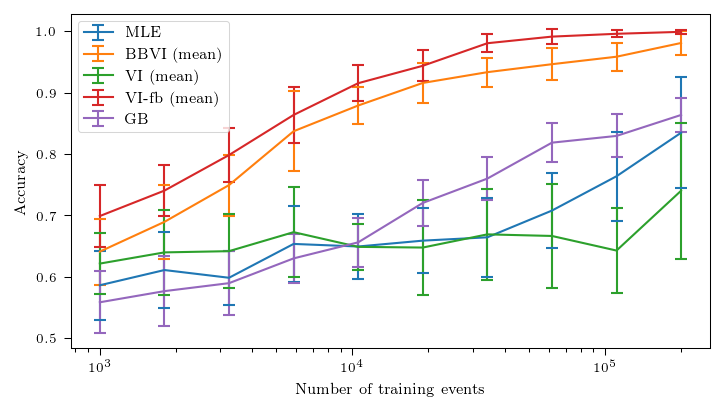

In [144]:
prefix = 'acc'
queries_list = [
    ('mle',                'MLE',          'C0', '-'), 
    ('bbvi_mean',          'BBVI (mean)',  'C1', '-'), 
    #('bbvi_mode',          'BBVI (mode)',  'C1', ':'),
    ('vi_mean',            'VI (mean)',    'C2', '-'),
    #('vi_mode',            'VI (mode)',    'C2', ':'),
    ('vi_fixed_beta_mean', 'VI-fb (mean)', 'C3', '-'),
    #('vi_fixed_beta_mode', 'VI-fb (mode)', 'C3', ':'),
    ('gb',                 'GB',           'C4', '-'),
]

plt.figure(figsize=(5.5, 2.95))
for suf, label, color, ls in queries_list:
    col = '_'.join([prefix, suf])
    plt.errorbar(df_plot.index, df_plot[col]['mean'], yerr=df_plot[col]['std'], 
                 label=label, color=color, linestyle=ls)
plt.legend()
plt.xlabel('Number of training events')
plt.xscale('log')
plt.ylabel('Accuracy');

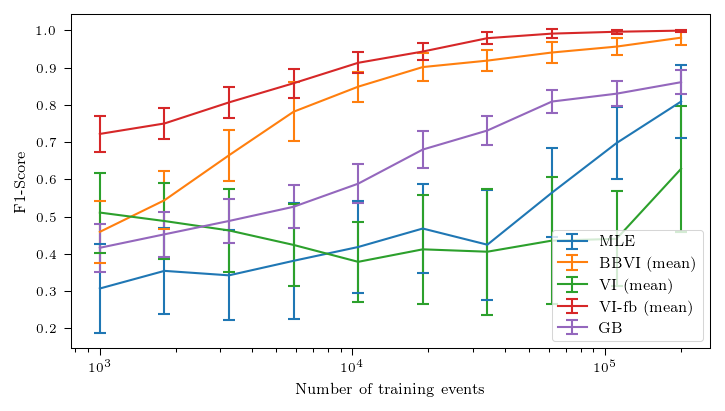

In [142]:
prefix = 'f1score'
queries_list = [
    ('mle',                'MLE',          'C0', '-'), 
    ('bbvi_mean',          'BBVI (mean)',  'C1', '-'), 
    #('bbvi_mode',          'BBVI (mode)',  'C1', ':'),
    ('vi_mean',            'VI (mean)',    'C2', '-'),
    #('vi_mode',            'VI (mode)',    'C2', ':'),
    ('vi_fixed_beta_mean', 'VI-fb (mean)', 'C3', '-'),
    #('vi_fixed_beta_mode', 'VI-fb (mode)', 'C3', ':'),
    ('gb',                 'GB',           'C4', '-'),
]

plt.figure(figsize=(5.5, 2.95))
for suf, label, color, ls in queries_list:
    col = '_'.join([prefix, suf])
    plt.errorbar(df_plot.index, df_plot[col]['mean'], yerr=df_plot[col]['std'], 
                 label=label, color=color, linestyle=ls)
plt.legend()
plt.xlabel('Number of training events')
plt.xscale('log')
plt.ylabel('F1-Score');

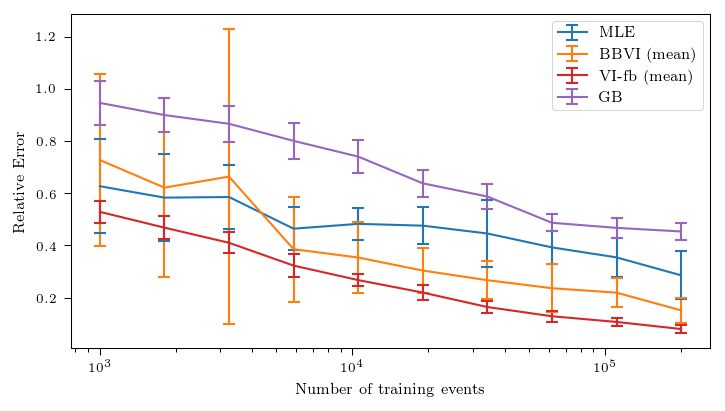

In [143]:
prefix = 'relerr'
queries_list = [
    ('mle',                'MLE',          'C0', '-'), 
    ('bbvi_mean',          'BBVI (mean)',  'C1', '-'), 
    #('bbvi_mode',          'BBVI (mode)',  'C1', ':'),
    #('vi_mean',            'VI (mean)',    'C2', '-'),
    #('vi_mode',            'VI (mode)',    'C2', ':'),
    ('vi_fixed_beta_mean', 'VI-fb (mean)', 'C3', '-'),
    #('vi_fixed_beta_mode', 'VI-fb (mode)', 'C3', ':'),
    ('gb',                 'GB',           'C4', '-'),
]

plt.figure(figsize=(5.5, 2.95))
for suf, label, color, ls in queries_list:
    col = '_'.join([prefix, suf])
    plt.errorbar(df_plot.index, df_plot[col]['mean'], yerr=df_plot[col]['std'], 
                 label=label, color=color, linestyle=ls)
plt.legend()
plt.xlabel('Number of training events')
plt.xscale('log')
plt.ylabel('Relative Error');

In [136]:
pd.DataFrame(all_data['mle']['history'])

,coeffs,loss,iter,time
0,"[0.263921322114094, 0.2581332773927039, 0.4645...",3.460486,500,0.179829
1,"[0.25783146830411946, 0.25303361003205543, 0.4...",3.433834,1000,0.187543
2,"[0.24942823208529924, 0.24603186372690247, 0.4...",3.399068,1500,0.185188
3,"[0.2388663639974656, 0.23729072685588232, 0.42...",3.356420,2000,0.189634
4,"[0.2262688081974404, 0.22695267594426433, 0.40...",3.306624,2500,0.194249
5,"[0.21187526032675427, 0.21525730515828068, 0.3...",3.251257,3000,0.194692
6,"[0.19618339008003893, 0.2026394671418724, 0.35...",3.193422,3500,0.187451
7,"[0.1800917047589407, 0.18981035461314333, 0.31...",3.138465,4000,0.155432
8,"[0.16495837854510714, 0.17776368525879532, 0.2...",3.093569,4500,0.147393
9,"[0.15237785827772643, 0.1675015285068917, 0.23...",3.062885,5000,0.148673


In [141]:
pd.DataFrame(all_data['bbvi']['history'])

,coeffs,loss,iter,time
0,"[0.13292622566223145, 0.17773926258087158, 0.1...",600906.457670,500,0.124176
1,"[0.12492980808019638, 0.16646593809127808, 0.1...",600535.174758,1000,0.114260
2,"[0.11985696852207184, 0.16953371465206146, 0.1...",600509.515132,1500,0.103940
3,"[0.11881543695926666, 0.17736190557479858, 0.1...",600600.992855,2000,0.105835
4,"[0.12020564824342728, 0.18420226871967316, 0.1...",600541.482991,2500,0.111615
5,"[0.12138146162033081, 0.1811361014842987, 0.14...",600518.592074,3000,0.118137
6,"[0.12848053872585297, 0.18678897619247437, 0.1...",600577.149278,3500,0.113832
7,"[0.13150864839553833, 0.19044747948646545, 0.1...",600601.669484,4000,0.111655
8,"[0.13675306737422943, 0.19586928188800812, 0.1...",600606.303750,4500,0.111571
9,"[0.13875551521778107, 0.18599507212638855, 0.1...",600578.210597,5000,0.101011


In [134]:
pd.DataFrame(all_data['vi']['history'])

,coeffs,loss,iter,time
0,"[0.004143097129148784, 0.03207655127112647, 0....",NaN,500,2.002942
1,"[0.0006217886281840047, 0.014406848914112128, ...",NaN,1000,1.960576
2,"[0.0004984994463933346, 0.008809944229127701, ...",NaN,1500,1.955240
3,"[0.0004912022778590955, 0.006018130452297605, ...",NaN,2000,1.893168
4,"[0.0004908899483484514, 0.0046300880961394585,...",NaN,2500,1.907111
5,"[0.0004908767125966553, 0.003870584491157285, ...",NaN,3000,1.886793
6,"[0.0004908761522954243, 0.003457620827672893, ...",NaN,3500,1.813424
7,"[0.0004908761268733022, 0.0032430517470193607,...",NaN,4000,1.788268
8,"[0.0004908761282849702, 0.003132670978648803, ...",NaN,4500,1.781478
9,"[0.0004908761287799415, 0.0030753907339753418,...",NaN,5000,1.760350


In [137]:
pd.DataFrame(all_data['vi-fixed-beta'])

,coeffs,loss,iter,time


In [11]:
df.loc[df.max_jumps == 100000]

,mle_baseline,mle_beta,mle_adjacency,mle_conv,mle_history,bbvi_loc,bbvi_log_scale,bbvi_coeffs_mean,bbvi_coeffs_mode,bbvi_adj_mean,...,gb_adj_normed,expId,outputIdx,baseline,beta,adjacency,dim,max_jumps,sim_seed_list,gen_seed


In [ ]:
df.max